# NEU502b fMRI Visual Respiration Blocks

In [1]:
import os, warnings
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from scripts.utilities import read_gifti
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
func_dir = 'preproc/fmriprep'
subjects = ['sub-01','sub-02']
tasks = ['visualbreathhold', 'visualhyperventilate']
spaces = ['fsaverage5.L','fsaverage5.R']

/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 1: Generate Task Regressors

In [2]:
from scripts.spm_hrf import spm_hrf

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Task metadata.
n_acq = 370
tr = 1

## Define upsampling level.
sfreq = 100

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Prepare save-directory.
out_dir = os.path.join('first_levels', 'regressors')
if not os.path.isdir(out_dir): os.makedirs(out_dir)

## Define TR onsets.
tr_onsets = np.arange(0, n_acq, tr)
    
## Generate HRF.
hrf = spm_hrf(1/sfreq)

for subj in subjects:
    
    for task in tasks:
    
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Load and prepare events.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Load events file.
        f = os.path.join('raw', subj, 'func', '%s_task-%s_events.tsv' %(subj,task))
        events = read_csv(f, sep='\t')

        ## Drop fixation cross.
        events = events[events.event == 'Checkerboard']

        ## Round onset times.
        events['onset'] = events['onset'].round(int(np.log10(sfreq)))

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Generate task regressors.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Initialize boxcars.
        times = np.linspace(0, n_acq + 1/sfreq, n_acq * sfreq).round(int(np.log10(sfreq)))
        boxcars = np.zeros_like(times)

        ## Generate boxcars.
        for onset, duration in events[['onset','duration']].values:
            ix = np.logical_and(times >= onset, times <= onset + duration)
            boxcars[ix] += 1

        ## Generate estimated hemodynamic response.
        hemo = np.convolve(boxcars, hrf)[:times.size]

        ## Downsample regressors.
        boxcars = boxcars[np.in1d(times, tr_onsets)]
        hemo = hemo[np.in1d(times, tr_onsets)]
        times = times[np.in1d(times, tr_onsets)]

        ## Scale estimated hemodynamic response.
        hemo /= hemo.max()

        ## Add 1-vector (intercept).
        regressors = hemo.reshape(-1,1)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ### Save task regressors.
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

        ## Save.
        f = os.path.join(out_dir, '%s_task-%s_events.txt' %(subj, task))
        np.savetxt(f, regressors)
    
print('Done.')

Done.


### Visualize example

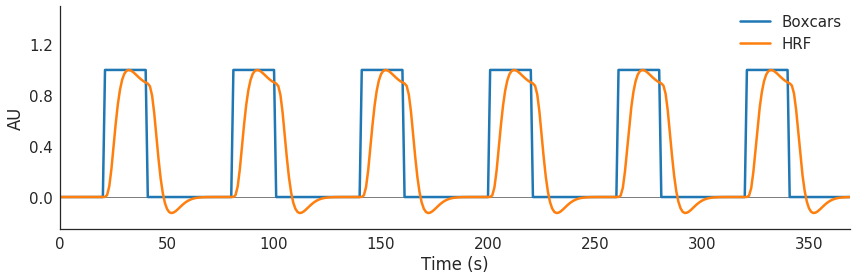

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.plot(times, boxcars, lw=2.5, label='Boxcars')
ax.plot(times, hemo, lw=2.5, label='HRF')

## Add info.
ax.hlines(0,0,times.max(),lw=0.5,zorder=0)
ax.set(xlim=(0,times.max()), xlabel='Time (s)', ylim=(-0.25,1.5), 
       yticks=np.arange(0,1.3,0.4), ylabel='AU')
ax.legend(loc=1, borderpad=0)

sns.despine()
plt.tight_layout()

## Step 2: First Level Analysis

In [ ]:
from scripts.prewhitening import prewhiten_data
from scripts.permutations import permutation_testing
from scripts.utilities import mask_insert
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Analysis parameters.
n_perm = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for task in tasks:
    
    ## Prepare save-directory.
    out_dir = os.path.join('first_levels', task)
    if not os.path.isdir(out_dir): os.makedirs(out_dir)
    
    for subj in subjects:

        for space in spaces:

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Load and prepare data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Load task regressors.
            f = os.path.join('first_levels','regressors','%s_task-%s_events.txt' %(subj,task))
            events = np.loadtxt(f)
            if events.ndim == 1: events = events.reshape(-1,1)
            _, n_task = events.shape

            ## Load motion regressors.
            f = os.path.join('first_levels','regressors','%s_task-%s_motion.txt' %(subj,task))
            motion = np.loadtxt(f)
            if motion.ndim == 1: motion = motion.reshape(-1,1)

            ## Load task data.
            f = os.path.join('first_levels','psc','%s_task-%s_space-%s.psc.npz' %(subj,task,space))
            npz = np.load(f)

            ## Prepare 
            data, mask = npz['psc'], npz['mask']
            Y = data[:,mask]

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Prewhiten data.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Construct design matrix.
            X = np.concatenate([events, motion], axis=-1)

            ## Prewhiten data (see script for details).
            WY, WX = prewhiten_data(Y, X)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### First-level regression.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Permutation testing (see script for details.)
            B, F, p = permutation_testing(WY, WX, n_task, n_perm)

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
            ### Save results.
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

            ## Save.
            f = os.path.join(out_dir, '%s_task-%s_space-%s.ces.npz' %(subj, task, space))
            np.savez_compressed(f, B=mask_insert(B,mask), F=mask_insert(F,mask), 
                                p=mask_insert(p,mask))

            ## Save PSC to checkerboard.
            for arr, name in zip([B,F,p], ['b','f','p']):

                obj = nib.Nifti1Image(mask_insert(arr,mask)[0], np.identity(4))
                f = os.path.join(out_dir, '%s_task-%s_space-%s.%s.nii.gz' %(subj, task, space, name))
                nib.save(obj, f)

print('Done.')

100%|██████████| 5000/5000 [14:31<00:00,  5.74it/s]


Done.


100%|██████████| 5000/5000 [13:25<00:00,  6.21it/s]
